In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import atecml.data

from contextlib import contextmanager
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegressionCV
#build Models...
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from imblearn.over_sampling import SMOTE, ADASYN
import random

plt.style.use('ggplot')

In [2]:
from lightgbm.sklearn import LGBMModel

In [23]:
model_type = 'gbdt'
target='Normal'

lgbm_params = {
    'boosting_type': model_type,
    'objective': 'regression',
    'use_missing' : 'true',
    'learning_rate': 0.05,
    'num_leaves': 64,  # we should let it be smaller than 2^(max_depth)
    'max_depth': -1,  # -1 means no limit
    'min_child_samples': 600,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'colsample_bytree': 0.9,
    'subsample': 0.85,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'min_child_weight': 0.05,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': 0.01,  # L1 regularization term on weights
    'reg_lambda': 0.1,  # L2 regularization term on weights
    'nthread': 40,
    'verbose': 0,
    'n_estimators' : 600,
    'metric':{'l2', 'auc'}
}

if (target == 'Normal'):
    params = {
        'scale_pos_weight' : 0.01
    }
else:
    params = {
        'scale_pos_weight' : 99
    }
lgbm_params.update(params)



clr = LGBMModel(**lgbm_params)

In [24]:
data = atecml.data.load_train()
train_df = atecml.data.filter_date(data,start_date='2017-09-05',end_date='2017-10-03')
val_df = atecml.data.filter_date(data,start_date='2017-10-04',end_date='2018-10-15')
predictors = [x for x in train_df.columns if x not in atecml.data.NOT_FEATURE_SUM]

lgbm_params

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.9,
 'learning_rate': 0.05,
 'max_bin': 100,
 'max_depth': -1,
 'metric': {'auc', 'l2'},
 'min_child_samples': 600,
 'min_child_weight': 0.05,
 'min_split_gain': 0,
 'n_estimators': 600,
 'nthread': 40,
 'num_leaves': 64,
 'objective': 'regression',
 'reg_alpha': 0.01,
 'reg_lambda': 0.1,
 'scale_pos_weight': 0.01,
 'subsample': 0.85,
 'subsample_for_bin': 200000,
 'subsample_freq': 1,
 'use_missing': 'true',
 'verbose': 0}

In [25]:
clr.fit(train_df[predictors],train_df[target],verbose=50)

LGBMModel(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
     learning_rate=0.05, max_bin=100, max_depth=-1, metric={'l2', 'auc'},
     min_child_samples=600, min_child_weight=0.05, min_split_gain=0,
     n_estimators=600, n_jobs=-1, nthread=40, num_leaves=64,
     objective='regression', random_state=None, reg_alpha=0.01,
     reg_lambda=0.1, scale_pos_weight=0.01, silent=True, subsample=0.85,
     subsample_for_bin=200000, subsample_freq=1, use_missing='true',
     verbose=0)

Ant-Score: 0.0008645533141210375


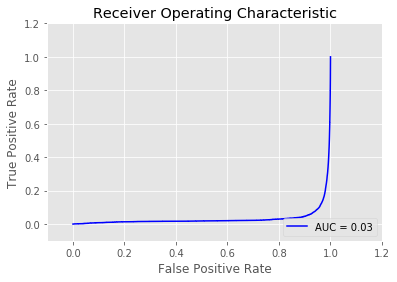

In [26]:
y_predict = clr.predict(val_df[predictors])
atec_Score,b,c=atecml.data.accuracy_validation(val_df['Fraud'],y_predict)

Ant-Score: 0.44654937054451693


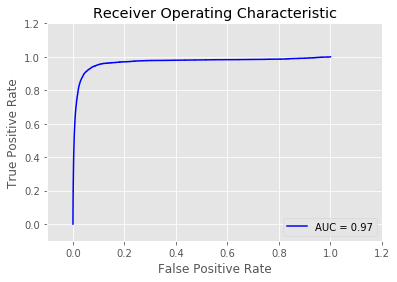

In [27]:
atec_Score,b,c=atecml.data.accuracy_validation(val_df['Fraud'],1-y_predict)

In [15]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(clr.apply(train_df[predictors]))

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [16]:
new=enc.transform(clr.apply(train_df[predictors]))

In [17]:
nfoo = pd.DataFrame(new.toarray())

In [18]:
nfoo

,0,1,2,3,4,5,6,7,8,9,...,6390,6391,6392,6393,6394,6395,6396,6397,6398,6399
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
val_pos = model_pos.predict(val_df[predictors],num_iteration=model_pos.best_iteration)
val_neg = model_neg.predict(val_df[predictors],num_iteration=model_neg.best_iteration)
val_r=pd.DataFrame()
val_r['score_pos'] = 1-val_pos
val_r['score_neg'] = val_neg


In [ ]:
val_r['score'] = val_r['score_pos']*0.1  + val_r['score_neg'] *0.9
a,b,c = atecml.data.accuracy_validation(val_df['Fraud'],val_r['score'])

In [ ]:
test_df = atecml.data.load_test()
y_proba_pos = model_pos.predict(test_df[predictors],num_iteration=model_pos.best_iteration)
y_proba_neg = model_neg.predict(test_df[predictors],num_iteration=model_neg.best_iteration)

In [ ]:
result=pd.DataFrame()
result['id'] = test_df['id']
result['score_pos'] = 1-y_proba_pos
result['score_neg'] = y_proba_neg
result['score'] = result['score_pos']*0.1  + result['score_neg'] *0.9

In [ ]:
result[['id','score']].to_csv('./submit_2018_06_26_02.csv',index=False)